# Data Science Brasil - Desafio Kaggle - Titanic
## Equipe:
* Ricardo Galiardi 
* Wanderson Henrique dos Santos
* Neri Silvestre Filho

## Datasets
### Treino
#### Columns
    * PassengerId: type should be integers
    * Survived: Survived or Not
    * Pclass: Class of Travel
    * Name: Name of Passenger
    * Sex: Gender
    * Age
    * SibSp: Number of Sibling/Spouse aboard
    * Parch: Number of Parent/Child aboard
    * Ticket
    * Fare
    * Cabin
    * Embarked: The port in which a passenger has embarked. C - Cherbourg, S - Southampton, Q = Queenstown
### Teste
##### Columns
    * PassengerId
    * Pclass
    * Name
    * Sex
    * Age
    * SibSp
    * Parch
    * Ticket
    * Fare
    * Cabin
    * Embarked
### Conversões
#### Columns
    * Sex:      {'female': 0, 'male': 1}
    * Age:      {"Missing": 0, "Infant": 1, "Child": 2, "Teenager": 3, "Adult": 4, "Senior": 5}
    * Fare:     {"Inferior": 0, "Basic": 1, "Superior": 2, "Executive": 3}
    * Title:    {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    * Embarked: {'S': 0, 'C': 1, 'Q': 2}
### Envio
#### Columns
    * PassengerId: integer
    * Survived: binary

### Variable Notes
* survival
    * 0 = No
    * 1 = Yes
* pclass: A proxy for socio-economic status (SES)
    * 1: 1st = Upper
    * 2: 2nd = Middle
    * 3: 3rd = Lower
* age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
* sibsp: The dataset defines family relations in this way...
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)
* parch: The dataset defines family relations in this way...
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    * Some children travelled only with a nanny, therefore parch=0 for them.
* embarked: 
    * C = Cherbourg
    * Q = Queenstown
    * S = Southampton 

In [ ]:
# Caso alguma biblioteca não esteja instalada (descomente a linha)

# Importando xgboost
#!pip install xgboost

# Caso seja necessário atualizar o pacote scikit
#!pip install --force-reinstall scikit-learn==0.20rc1

In [1]:
# Importando os módulos das bibliotecas de Data Science

import numpy as np
import pandas as pd      
import matplotlib.pyplot as plt   
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import Functions as fn

# Faz com que os relatórios (plots) sejam apresentados em uma célula e não em uma nova janela
%matplotlib inline       

In [2]:
# Prepara os dados - importando os datasets

dsTrain = pd.read_csv('train.csv', 
                      names=['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0, dtype={'Age': np.float64})

dsTest  = pd.read_csv('test.csv',  
                      names=['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], 
                      sep=',', header=0, dtype={'Age': np.float64})

In [3]:
# Verificando os primeiros registros de Treino

dsTrain.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Obtendo as informações do dataset de Treino

dsTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [5]:
# Verificando os dados missing do dataset de Treino

dsTrain.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

In [6]:
# Cria um dataset com os dois datasets: Treino e de Testes para podermos tratar as variáveis de uma só vez

# Cria novos datasets com a coluna do tipo: treino: 0 e teste: 1
mTrain = dsTrain.copy()
mTest = dsTest.copy()

# Incluíndo as colunas de checagem
mTrain['Type'] = 'Train'
mTest['Type']  = 'Test'

#dsCombined = pd.concat([mTrain, mTest], axis=0, join='outer', join_axes=None, ignore_index=True, keys=['PassengerId'], sort=False)
dsCombined = mTrain.append(mTest, ignore_index=True, sort=False)
#pd.merge([mTrain, mTest], sort=False)

dsCombined.isnull().any()

PassengerId    False
Survived        True
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked        True
Type           False
dtype: bool

In [7]:
dsCombined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Train


In [8]:
dsCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Survived       891 non-null float64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1046 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1308 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Type           1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


In [9]:
# Limpeza dos dados e tratamento de dados missing
## Pela avaliação teremos que tratar as colunas: Age e Embarked, não iremos tratar Cabin, por não ser relevante
## E criar novos campos de tratamento

#New
dsCombined['FamilySize'] = 0
dsCombined['IsAlone'] = 0

#Survived
dsCombined['Survived'] = dsCombined['Survived'].fillna('-1').astype(int)

#Cabin
dsCombined['Cabin'] = dsCombined['Cabin'].str[0].fillna('G')

#Age
dsCombined['Pclass'] = dsCombined['Pclass'].astype(int)

#SibSp and Parch
dsCombined['FamilySize'] = dsCombined['SibSp'] + dsCombined['Parch'] + 1

#Size
dsCombined.loc[dsCombined['FamilySize'] == 1, 'IsAlone'] = 1

#Embarked
dsCombined['Embarked'] = dsCombined['Embarked'].fillna('S')

#Fare
dsCombined['Fare'] = dsCombined['Fare'].fillna(dsCombined['Fare'].notna().median())

#Age
dsCombined['Age'] = dsCombined['Age'].fillna(dsCombined['Age'].notna().median())

#Title
dsCombined['Title'] = dsCombined['Name'].apply(fn.getTitle)
dsCombined['Title'] = dsCombined['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dsCombined['Title'] = dsCombined['Title'].replace('Mlle', 'Miss')
dsCombined['Title'] = dsCombined['Title'].replace('Ms', 'Miss')
dsCombined['Title'] = dsCombined['Title'].replace('Mme', 'Mrs')

In [10]:
dsCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int32
Pclass         1309 non-null int32
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Type           1309 non-null object
FamilySize     1309 non-null int64
IsAlone        1309 non-null int64
Title          1309 non-null object
dtypes: float64(2), int32(2), int64(5), object(7)
memory usage: 153.5+ KB


In [11]:
dsCombined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G,S,Train,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Train,2,0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G,S,Train,1,1,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Train,2,0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,G,S,Train,1,1,Mr


In [12]:
# Normalização dos dados

# Mapping Sex
fn.setSex(dsCombined, 'Sex')

# Mapping titles
fn.setTitle(dsCombined, 'Title')

# Mapping Embarked
fn.setEmbarked(dsCombined, 'Embarked')

# Mapping Fare
fn.setFare(dsCombined, 'Fare')

# Mapping Age
fn.setAge(dsCombined, 'Age')

In [13]:
dsCombined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int32
Pclass         1309 non-null int32
Name           1309 non-null object
Sex            1309 non-null int32
Age            1309 non-null int64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null int64
Cabin          1309 non-null object
Embarked       1309 non-null int32
Type           1309 non-null object
FamilySize     1309 non-null int64
IsAlone        1309 non-null int64
Title          1309 non-null int32
dtypes: int32(5), int64(7), object(4)
memory usage: 138.1+ KB


In [14]:
dsCombined.iloc[0::, 1::].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Type,FamilySize,IsAlone,Title
0,0,3,"Braund, Mr. Owen Harris",1,4,1,0,A/5 21171,1,G,0,Train,2,0,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,5,1,0,PC 17599,4,C,1,Train,2,0,3
2,1,3,"Heikkinen, Miss. Laina",0,4,0,0,STON/O2. 3101282,1,G,0,Train,1,1,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,113803,3,C,0,Train,2,0,3
4,0,3,"Allen, Mr. William Henry",1,4,0,0,373450,1,G,0,Train,1,1,1
5,0,3,"Moran, Mr. James",1,1,0,0,330877,1,G,2,Train,1,1,1
6,0,1,"McCarthy, Mr. Timothy J",1,5,0,0,17463,3,E,0,Train,1,1,1
7,0,3,"Palsson, Master. Gosta Leonard",1,1,3,1,349909,2,G,0,Train,5,0,4
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,4,0,2,347742,2,G,0,Train,3,0,3
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,3,1,0,237736,3,G,1,Train,2,0,3


In [63]:
# Seleção das variáveis que não serão usadas pelo modelo

#drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize']
train = dsCombined.loc[dsCombined['Type'] == 'Train']
drop_elements = ['Name', 'Ticket', 'Cabin', 'FamilySize', 'Type']
train = train.drop(drop_elements, axis = 1)
test = dsCombined.loc[dsCombined['Type'] == 'Test']
drop_elements = ['Survived', 'Name', 'Ticket', 'Cabin', 'FamilySize', 'Type']
test = test.drop(drop_elements, axis = 1)

print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  \
0            1         0       3    1    4      1      0     1         0   
1            2         1       1    0    5      1      0     4         1   
2            3         1       3    0    4      0      0     1         0   
3            4         1       1    0    4      1      0     3         0   
4            5         0       3    1    4      0      0     1         0   

   IsAlone  Title  
0        0      1  
1        0      3  
2        1      2  
3        0      3  
4        1      1  
     PassengerId  Pclass  Sex  Age  SibSp  Parch  Fare  Embarked  IsAlone  \
891          892       3    1    4      0      0     1         2        1   
892          893       3    0    5      1      0     1         0        0   
893          894       2    1    5      0      0     1         2        1   
894          895       3    1    4      0      0     1         0        1   
895          896       3    0    4    

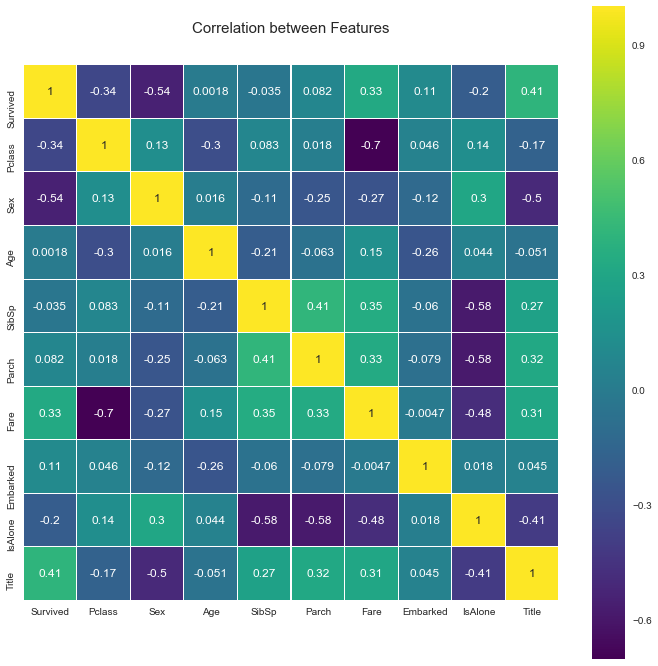

In [64]:
# Verificando a correlação entre as variáveis do dataset de Treino (Primeira validação)

fn.getCorr(train.iloc[0::, 1::])

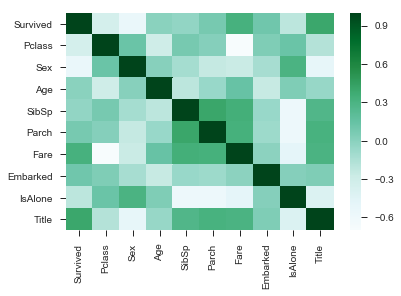

In [30]:
sns.heatmap(train.iloc[0::, 1::].corr(), cmap='BuGn')

In [65]:
# Treino - Criando os arrays de X e y, com as variáveis independentes e a variável predictora

X_train = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsAlone', 'Title']]
y_train = train['Survived']

In [66]:
# Teste - Criando os arrays de X e y, com as variáveis independentes e a variável predictora

X_test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'IsAlone', 'Title']]

In [67]:
# Split de treino

# Importando a biblioteca que faz o split dos dados
#from sklearn.model_selection import train_test_split

# Separando os dados
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.4, random_state=101)

In [68]:
# Criando e treinando o modelo

# Importando a biblioteca que faz Regressão linear
## A regressão, em geral, tem como objectivo tratar de um valor que não se consegue estimar inicialmente.
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [70]:
# Predições do nosso modelo e sua visão atráves do gráfico

predictions = lm.predict(X_test)

In [71]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

Confusion Matrix


,true,false
true,501,48
false,109,233


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


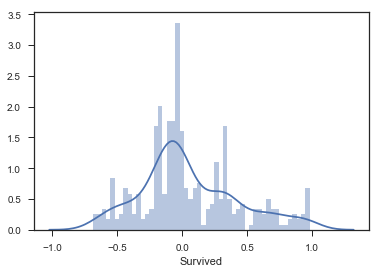

In [39]:
# Histograma residual

sns.distplot((y_test-predictions), bins=50)

## Métricas de avaliação de regressão


Aqui estão três métricas de avaliação comuns para problemas de regressão:

**Mean absolute error ** (erro absoluto médio) (MAE) é a média do valor absoluto dos erros:

$$\frac 1n\sum_{i=1}^n|y_i-\hat{y}_i|$$

** Mean Squared Error ** (erro médio quadrático) (MSE) é a média dos erros quadrados:

$$\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2$$

** Root Mean Square Error ** (raiz do erro quadrático médio) (RMSE) é a raiz quadrada da média dos erros quadrados:

$$\sqrt{\frac 1n\sum_{i=1}^n(y_i-\hat{y}_i)^2}$$

Comparando estas métricas:

- **MAE** é o mais fácil de entender, porque é o erro médio.
- **MSE** é mais popular que o MAE, porque a MSE "puniria" erros maiores, o que tende a ser útil no mundo real.
- **RMSE** é ainda mais popular do que MSE, porque o RMSE é interpretável nas unidades "y".

Todas estas são ** funções de perda **, porque queremos minimizá-las.

In [40]:
# Avaliando a métrica de avaliação da Regressão

# Importando a biblioteca que faz a Métrica
from sklearn import metrics

print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 0.2820009471511782
MSE: 0.14061329992325575
RMSE: 0.3749843995731766


In [41]:
# Importação dos classificadores

# Suprime erros
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LinearRegression, LogisticRegression
from xgboost import XGBClassifier

In [72]:
# Cria a Comparação dos classificadores

classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=100, oob_score = True),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(),
    LinearRegression(),
    XGBClassifier()]

splits = 2
cols = ["Classifier", "Accuracy"]
acc_dict = {}
log = pd.DataFrame(columns=cols)
count = 0

#shuff = KFold(n_splits=splits, random_state=42, shuffle=True)
#shuff = ShuffleSplit(n_splits=splits, test_size=0.3, random_state=0)
#shuff = StratifiedShuffleSplit(n_splits=splits, test_size=0.4, random_state=0)

#for train_index, test_index in shuff.split(X, y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]

for clf in classifiers:
    name = clf.__class__.__name__
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    count += 1
    if name in acc_dict:
        acc_dict[name] += acc
    else:
        acc_dict[name] = acc

for clf in acc_dict:
    acc_dict[clf] = acc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, acc_dict[clf]]], columns=cols)
    log = log.append(log_entry)
    
acc_dict

ValueError: Found input variables with inconsistent numbers of samples: [112, 418]

,
Classifier,Accuracy
AdaBoostClassifier,0.084821
GradientBoostingClassifier,0.083929
KNeighborsClassifier,0.083929
SVC,0.083036
XGBClassifier,0.083036
RandomForestClassifier,0.082143
DecisionTreeClassifier,0.081250
LogisticRegression,0.081250
LinearDiscriminantAnalysis,0.079464


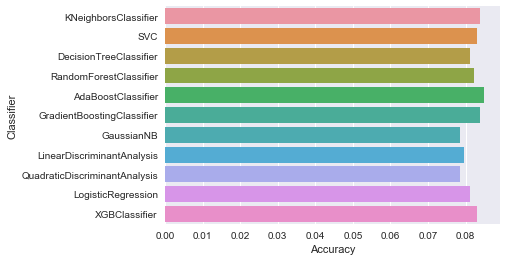

In [54]:
# Verifica a acurácia por tipo de classificação

sns.set(style="darkgrid")
sns.barplot(x='Accuracy', y='Classifier', data=log)

log.groupby(['Classifier', 'Accuracy']).count().sort_values(by=['Accuracy'], ascending=False)

In [51]:
# Com base no melhor classificador, é gerada a Predicção.

classifier = XGBClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(X_test)

In [52]:
# Cria a matriz de Confusao: Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

print('Confusion Matrix')
predictions = cross_val_predict(classifier, X_train, y_train, cv=3)
pd.DataFrame(confusion_matrix(y_train, predictions), columns=['true', 'false'], index=['true', 'false'])

Confusion Matrix


,true,false
true,145,19
false,30,67


In [ ]:
# Cria o Dataframe com os dados para envio ao Kaggle

dssubmission = pd.DataFrame({'PassengerId': ds['PassengerId'], 'Survived': predictions})

In [ ]:
# Converte o DataFrame para um arquivo csv para envio ao Kaggle
filename = 'kaggle_titanic.csv'

dssubmission.to_csv(filename, index=False)